# Temporal point processes #

From now on, we shall consider point processes which _do_ evolve in time.
- At it's simplest, this is just a sequence of events which occur at times $\cdots < t_0 < t_1 < t_2 < \cdots$
- We denote the history of the system up to time $t$ by $\mathcal{H}_t$.
- We shall follow the common notation and write $f^*(t) = f(t|\mathcal{H}_t)$ for the condition density function of the time of the _next_ event, given the history so far.  The $*$ reminds up of this conditionality.

The most simple case is when, if $t_{n-1}<t$ was the last event, then $f^*(t) = f(t-t_{n-1})$ where $f$ is some fixed density function.  That is, the "gaps" between events are all independently, identically distributed.
- This is a [Renewal process](https://en.wikipedia.org/wiki/Renewal_theory)
- The Poisson process has $f(s) = \lambda e^{-\lambda s}$ an exponential distribution.

More interesting behaviour comes when we let $f^*$ depend upon the history of the system in a more complicated way.

Working with $f^*$ is technically hard.  Instead, we define the _intensity function_
$$ \lambda^*(t) = \frac{f^*(t)}{1-F^*(t)} $$
where $F^*(t)$ is the cumulative distribution function.  One can show that:

- $\lambda^*(t)$ represents the expected number of events which will occur close to $t$ (conditional on $\mathcal{H}_t$).
- This justifies the terminology "intensity" function
- A simple Poisson process has $\lambda^*(t) = \lambda$ a constant
- A time varying Poisson process has $\lambda^*(t) = \lambda(t)$ a function of $t$ (which is independent of $\mathcal{H}_t$).

# Self-exciting processes #

These are called [Hawkes processes](http://mathworld.wolfram.com/HawkesProcess.html) in the Financtial Mathematics / Statistics literature, but "self-exiciting processes" more generally.

We set
$$ \lambda^*(t) = \mu + \alpha \sum_{t_i<t} \exp(-(t-t_i)) $$

We interpret this as follows:

- $\mu$ is the "background intensity" at which events occur "at random".  If $\alpha=0$ then we get a Poisson process with intensity $\mu$.
- Each event $t_i$ is the past (the condition $t_i<t$) adds to the intensity with an exponentially decaying term $\alpha \exp(-(t-t_i))$.
- Thus shortly after one event occurs, an intensity of $\alpha$ is added, this decaying to $0$ as time becomes large.
- Thus the process "self excites".

This process can be used to model trades on a stock-market, or earthquakes (where a "random" quake can set-off after shocks) or gang-related crime (where a "random" crime can set-off retaliation).

We should note that more complicated forms for $\lambda^*$ certainly exist-- for example, aftershocks caused by an Earthquake are modelled using a power law, instead of exponential decay.

# Simulation #

The _integrated conditional intensity function_ (or integrated Hazard function, or _compensator_) is
$$ \Lambda^*(t) = \int_0^t \lambda^*(s) \ ds $$

Of interest to us is the following result:

- If $(s_i)$ is a (unit rate) Poisson process, then $t_i = \Lambda^*(s_i)$ is a point process with intensity $\lambda^*(t_i)$.

Of course, in all but the easiest situations, $\Lambda^*$ depends on the $(t_i)$, and so solving $t_i = \Lambda^*(s_i)$ where we know $(s_i)$ but not $(t_i)$ is rather hard (and if it is possible at all requires typically an iterative approach like Newton–Raphson).

An easier approach is "Otaga's modified thinning algorithm" (due to Otaga) which is a "rejection" technique.  We sample from a Poisson process with a "too high" intensity and then discard samples to get back to the intensity we need.

- Suppose we are at time $t$.
- We simulate a (simple, homogeneous) Poisson process with constant intensity $m$ to pick the next possible point $t'$.
- We require that $m$ is greater than the maximum of $\lambda^*(s)$ for $s\geq t$
- (For us, this is fine, as $\lambda^*$ will decay for large $s$.  In general, we might only look at an interval $[t,t+l]$ and possibly work through many intervals before picking a point).
- Generate a random sample $u$ from a uniform distribution on $[0,1]$
- Accept $t'$ if $\lambda^*(t') / m \geq u$, that is, $t_{i+1}=t'$
- Otherwise we update $t$ to $t+t'$ and try again to find $t_{i+1}$

In [45]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import utils

In [46]:
def hawkes_intensity(mu, alpha, points, t):
    """Find the hawkes intensity:
    mu + alpha * sum( np.exp(-(t-s)) for s in points if s<=t )
    """
    p = np.array(points)
    p = p[p <= t]
    p = np.exp(p - t) * alpha
    return mu + np.sum(p)
    #return mu + alpha * sum( np.exp(s - t) for s in points if s <= t )

assert(np.isclose(1, hawkes_intensity(1,2,[],5)))
assert(np.isclose(2, hawkes_intensity(0,2,[5],5)))
assert(np.isclose(4, hawkes_intensity(2,2,[4.9999999],5)))
assert(np.isclose(2, hawkes_intensity(0,2,[4.9999999, 8],5)))
assert(np.isclose(1, hawkes_intensity(1,2,[5, 8],4)))

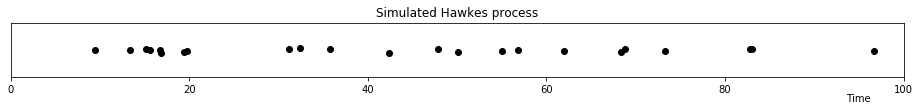

In [47]:
def simulate_hawkes(mu, alpha, window):
    t = 0
    points = []
    all_samples = []
    while t < window:
        m = hawkes_intensity(mu, alpha, points, t)
        s = np.random.exponential(scale = 1/m)
        ratio = hawkes_intensity(mu, alpha, points, t + s) / m
        if ratio >= np.random.uniform():
            points.append(t + s)
        all_samples.append(t + s)
        t = t + s
    return points, all_samples

window = 100
mu = 0.2
alpha = 0.05

points, all_samples = simulate_hawkes(mu, alpha, window)
    
utils.plot_series(points, "Simulated Hawkes process")

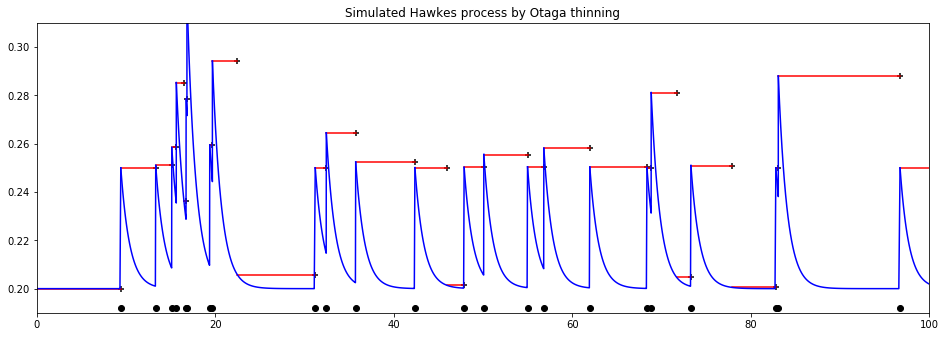

In [48]:
def add_intensity(ax, start, end, color):
    x = np.arange(101) / 100
    x = start + x * (end - start)
    y = [hawkes_intensity(mu, alpha, points, t) for t in x]
    ax.plot(x,y, color)

def add_homogeneous_intensity(ax, start, end, color):
    x = [start, end]
    y = hawkes_intensity(mu, alpha, points, start)
    y = [y, y]
    ax.plot(x,y, color)
    
width, _ = utils.slim_aspect()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(width, width/3))

ax.set(ylim=[0.19,0.31], xlim=[0,100])
ax.set(title="Simulated Hawkes process by Otaga thinning")

ax.scatter(points, [0.192 for _ in points], marker='o', color="black")

add_homogeneous_intensity(ax, 0, all_samples[0], "red")
for (s, e) in zip(all_samples[:-1], all_samples[1:]):
    add_homogeneous_intensity(ax, s, e, "red")

add_intensity(ax, 0, points[0], "blue")
for i in range(1, len(points)):
    add_intensity(ax, points[i-1], points[i], "blue")

y = [hawkes_intensity(mu, alpha, points, t) for t in [0] + all_samples[:-1]]
_ = ax.scatter(all_samples, y, marker="+", color="black")

In this plot, we show the resulting Hawkes process at the bottom,

- Plot the varying intensity function in blue
- Plot of homogeneous Poisson process (of "proposal samples") in red
- Plot the proposals with the mark "+".  Not all of these are accepted.

To verify that our simulation is correct, we can go back to the claim above and use the converse (which also holds!)

- If $(t_i)$ is a point process with intensity $\lambda^*(t_i)$ then $s_i = \Lambda^*(t_i)$ gives a unit rate Poisson process.

Integrating $\lambda^*$ using an out of the box numerical package is hampered by the discontinuities.  Furthermore, a slightly naive approach is rather slow in Python.  So just us perform some precalculation.  We will only be interested in the values $\Lambda^*(t_i)$,
\begin{align*} \Lambda^*(t_i) &= \int_0^{t_i} \lambda^*(s) \ ds =
\int_0^{t_0} \lambda^*(s) \ ds + \sum_{j=0}^{i-1} \int_{t_j}^{t_{j+1}} \lambda^*(s) \ ds \\
&= \int_0^{t_0} \mu \ ds + \sum_{j=0}^{i-1} \int_{t_j}^{t_{j+1}} \mu + \alpha\sum_{k=0}^{j} \exp(-(s-t_k)) \ ds \\
&= \int_0^{t_i} \mu \ ds + \alpha \sum_{k=0}^{i-1} \int_{t_k}^{t_i} \exp(-(s-t_k)) \ ds \\
&= \mu t_i + \alpha \sum_{k=0}^{i-1}\Big(1-\exp(-(t_i-t_k))\Big)
\end{align*}

In [49]:
def Lambda(mu, alpha, points, index):
    sum_gen = ( 1 - np.exp(points[k]- points[index]) for k in range(index) )
    return mu * points[index] + alpha * sum(sum_gen)

def transform_via_Lambda(mu, alpha, points):
    return [Lambda(mu,alpha,points,i) for i in range(len(points))]

assert(np.isclose(1, Lambda(1,0,[1],0)))
assert(np.isclose(1, Lambda(1,2,[1,3],0)))
assert(np.isclose(5 - 2 * np.exp(-2), Lambda(1,2,[1,3],1)))

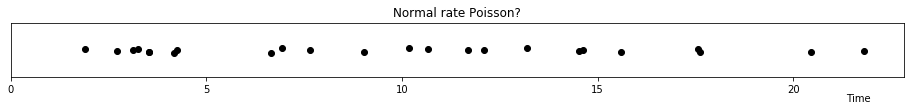

In [50]:
poisson_points = transform_via_Lambda(mu,alpha,points)

utils.plot_series(poisson_points, "Normal rate Poisson?", [0,max(poisson_points)+1])

In [52]:
gaps = []
index = 5

for _ in range(10000):
    points, _ = simulate_hawkes(0.2, 0.05, 100)
    if len(points) < index+1:
        raise Exception("Generated process too short")
    gaps.append( Lambda(mu,alpha,points,index+1) - Lambda(mu,alpha,points,index) )

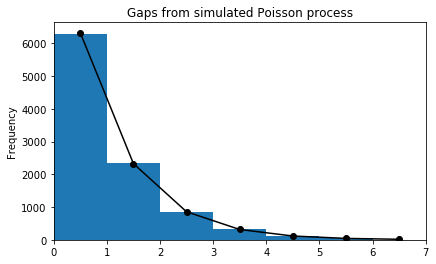

In [53]:
def exponential(a, b):
    return scipy.stats.expon.cdf(b, scale=1.0) - scipy.stats.expon.cdf(a, scale=1.0)

expected = { x : exponential(x, x+1) for x in range(20) }
utils.histogram_continuous(gaps, 1, expected, "Gaps from simulated Poisson process")

# Simulation via Branching processes #

The Hawkes process has another interpretation in terms of a branching process.  Notice that the intensity function is _linear_ in that adding a new point to the process just adds a new summand.  This allows us to split the process into a number of sub-processes.

Suppose that the intensity function has the general form
$$ \lambda^*(t) = \mu + \sum_{t_i<t} \mu(t-t_i). $$

- Following the literature, we say that an event generated from the background intensity $\mu$ is an "immigrant".
- Each immigrant creates a sub-process (the events of which are the "offspring" of the immigrant) in the following iterative way:
- Say that $t_{0,i}$ is an immigrant.
- Then $t_{0,i}$ generates events at a rate $\mu(t-t_{0,i})$ for $t>t_{0,i}$.
- Generate samples from this inhomogeneous Poisson process, say $(t_{1,i,j})_{j\geq 0}$.
- Each $t_{1,i,j}$ generates events at a rate $\mu(t-t_{1,i,j})$, leading to $(t_{2,i,j,k})_{k\geq 0}$
- And so forth.

To make this efficient (in our particular case), we wish to sample from Poisson processes with intensity function
$$ f(t) = \alpha \exp(-t). $$
In this case, the compensator is
$$ F(t) = \int_0^t \alpha \exp(-s) \ ds = \alpha(1 - \exp(-t)). $$

- Thus, we can simulate a unit rate Poisson process $(s_i)$.
- Then we solve $s_i = F(t_i)$.
- That is, $t_i = \log\big(\alpha / (\alpha - s_i) \big)$, where we discard any $s_i \geq \alpha$.

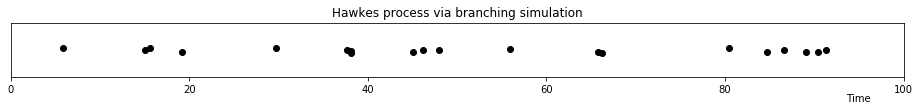

In [78]:
def simulate_sub_process(alpha, start_time):
    points = []
    t = 0
    while True:
        t += np.random.exponential()
        if t >= alpha:
            return points
        points.append(start_time + np.log(alpha/(alpha-t)))
    
def simulate_hawkes_via_branching(mu, alpha, window_size=100):
    points = utils.sample_poisson_process(window_size, 1/mu)
    to_process = list(points)
    while len(to_process) > 0:
        next_point = to_process.pop()
        for t in simulate_sub_process(alpha, next_point):
            if t < window_size:
                points.append(t)
                to_process.append(t)
    points.sort()
    return points

points = simulate_hawkes_via_branching(mu, alpha)
utils.plot_series(points, "Hawkes process via branching simulation")

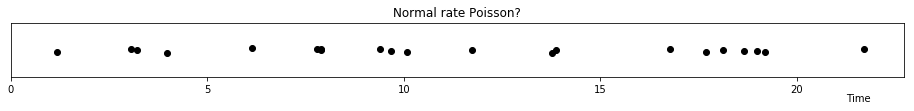

In [79]:
poisson_points = transform_via_Lambda(mu,alpha,points)

utils.plot_series(poisson_points, "Normal rate Poisson?", [0,max(poisson_points)+1])

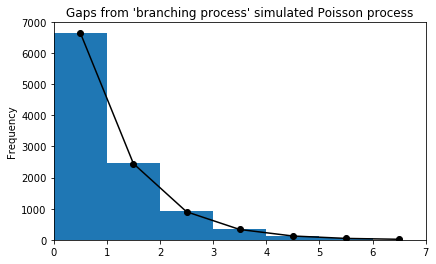

In [81]:
points = simulate_hawkes_via_branching(mu,alpha,50000)
poisson_points = np.array(transform_via_Lambda(mu,alpha,points))
gaps = poisson_points[1:] - poisson_points[:-1]

expected = { x : exponential(x, x+1) for x in range(20) }
utils.histogram_continuous(gaps, 1, expected, "Gaps from 'branching process' simulated Poisson process")

# A note on stationality #

The idealised Hawkes process should be "stationary", which here means "time invariant".  A "typical" window of the process should look no different now compared to in the future.

However, our convention above has been to start at time $0$, and this breaks stationality.

- For small values of $\alpha$, however, we can see that very quickly the "self-exiciting" nature of the process dies down.
- Hence it is intuitively clear that after some "bedding in" time, our simulation should be time invariant.

In the literature, there is a comparison between "perfect" simulations, which takes account of time before $0$, and our slightly more "naive" approach.